### Домашнее задание Transformers Training (50 баллов)

В этом домашнем задании требуется обучить несколько Transformer-based моделей в задаче машинного перевода. Для обучения можно воспользоваться текущим проектом, так и реализовать свой пайплайн обучения. Если будете использовать проект, теги **TODO** проекта отмечают, какие компоненты надо реализовать.
В ноутбуке нужно только отобразить результаты обучения и выводы. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Ваш код обучения нужно выложить на ваш github, в строке ниже дать ссылку на него. В первую очередь будут оцениваться результаты в ноутбуке, код нужен для проверки адекватности результатов. 

Обучать модели до конца не нужно, только для демонстрации, что модель обучается и рабочая - снижение val_loss, рост bleu_score.

#### Сcылка на ваш github с проектом (ветка hw) - https://github.com/dinoair/pytorch-machine-translation/tree/main

Ноутбук с результатами выкладывать на ваш **google диск** курса. 

### Данные

`
wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip
`

Модели нужно обучить на задаче перевода с английского на русский.

In [24]:
!wget https://www.manythings.org/anki/rus-eng.zip && unzip rus-eng.zip

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


--2023-05-25 16:54:49--  https://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460248 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

     0K .......... .......... .......... .......... ..........  0%  136K 1m50s
    50K .......... .......... .......... .......... ..........  0% 4.22M 57s
   100K .......... .......... .......... .......... ..........  0%  291K 55s
   150K .......... .......... .......... .......... ..........  1%  422M 41s
   200K .......... .......... .......... .......... ..........  1%  273K 44s
   250K .......... .......... .......... .......... ..........  1%  350M 36s
   300K .......... .......... .......... .......... ..........  2%  474M 31s
   350K .......... .......... .......... .......... ..........  2% 4.51M 27s
   400K .......... .......... .......... ..

### Обучение Seq2seq Transformer модель(25 баллов)

Реализуйте Seq2seq Transformer. В качестве блока трансформера можно использовать https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html. В качестве токенизатора воспользуйтесь HuggingFace токенизатор для source/target языков - https://huggingface.co/docs/transformers/fast_tokenizers
В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. 

Не забудьте остальные элементы модели:
* Мы можем использовать 1 трансформер как энкодер - декодером будет выступать линейный слой. 
* Обучите свой BPE токенизатор - https://huggingface.co/docs/transformers/fast_tokenizers
* Матрицу эмбеддингов токенов
* Матрицу позиционных эмбеддингов
* Линейный слой проекции в target словарь
* Функцию маскирования будущих состояний attention, так как модель авто-регрессионна
* Learning rate scheduler


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, размерность скрытого слоя, количество слоев
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [39]:
#!g1.1
data_config = yaml.load(open("configs/data_config.yaml", 'r'), Loader=yaml.Loader)
model_config = yaml.load(open("configs/transformer_config.yaml", 'r'), Loader=yaml.Loader)
print_learning_parameters(transformer_data_config, model_config)

Parameters of the model:
learning rate: 0.0001
batch size: 256
embeddings size: 512


In [64]:
#!g1.1
import sys  
sys.path.insert(1, "./src")
import torch
import yaml
from models import trainer
from data.datamodule import DataManager

In [49]:
from txt_logger import TXTLogger
from models.seq2seq_transformer import Seq2SeqTransformer

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

data_config = yaml.load(open("configs/data_config.yaml", "r"), Loader=yaml.Loader)
dm = DataManager(data_config, DEVICE)
train_dataloader, dev_dataloader = dm.prepare_data()

model_config = yaml.load(open("configs/transformer_config.yaml", "r"), Loader=yaml.Loader)

# TODO: Инициализируйте модель Seq2SeqTransformer
model = Seq2SeqTransformer(
    device=DEVICE,
    encoder_vocab_size=len(dm.source_tokenizer.index2word),
    decoder_vocab_size=len(dm.target_tokenizer.index2word),
    target_tokenizer=tran_dm.target_tokenizer,
    start_symbol=tran_dm.target_tokenizer.sos_token,
    lr=model_config['learning_rate'],
    total_steps=model_config['epoch_num']*len(train_dataloader),
    emb_size=model_config['emb_size'],
    num_heads=model_config['num_heads'],
    num_encoder_layers=model_config['num_encoder_layers'],
    num_decoder_layers=model_config['num_decoder_layers'],
    dropout=model_config['dropout'],
    div_factor=model_config['div_factor']
)
logger = TXTLogger("training_logs")
trainer_cls = trainer.Trainer(model=model, model_config=model_config, logger=logger)

if model_config["try_one_batch"]:
    train_dataloader = [list(train_dataloader)[0]]
    dev_dataloader = [list(train_dataloader)[0]]
trainer_cls.train(train_dataloader, dev_dataloader)

Reading from file: 100%|██████████| 467119/467119 [00:08<00:00, 52256.99it/s]


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]

  0%|          | 0/961 [00:00<?, ?it/s]

  0%|          | 0/240 [00:00<?, ?it/s]







Current BLEU:  0.0
о хочу знать действительно ли ты понимаешь ---> о не что не
о не думал что нам стоит говорить об этом тому ---> о не не не не не
мэри потеряла мужа у дтп ---> том не не у
он был не больше футбольного мяча ---> не не не не
это о рассказал тому е том что случилось ---> о не что что что что
##############################
Current BLEU:  0.0
не могу вспомнить где о купил эту пару перчаток ---> о не не могу о не о не
два брата не могли поладить друг ф другом ---> у у не не не
он выключил свет я отправился у постель ---> он он у у у у
о не знал что за мной кто то наблюдает ---> о не не что что мне
о сомневаюсь что носитель языка так бы выразился ---> о не не это это это
##############################
Current BLEU:  0.01684152950208988
ты скажешь ему об этом когда он придёт домой ---> ты ты что что что что что
о надеюсь что увижу его у понедельник ---> о что что что что
о думаю это было бы слишком сложно сделать ---> думаю что это это это это
обязательно настанет день 

In [72]:
#!g1.1
input_tensor, target_tensor = dev_dataloader.__iter__().__next__()
input_tensor = input_tensor[:10]
target_tensor = target_tensor[:10]
with torch.no_grad():
    predicted_samples, _ = model.forward(input_tensor)
bleu_score, target_sentences, predicted_sentences = model.eval_bleu(predicted_samples, target_tensor)
print(f'BLEU score: {bleu_score}')
for source_tokens, target_tokens, predicted_tokens in zip(input_tensor, target_sentences, predicted_sentences):
    source_tokens = ' '.join(dm.source_tokenizer.decode(source_tokens.tolist()))
    print("\nSource: ", source_tokens, "\tTarget: ", target_tokens, "\tPredicted: ", predicted_tokens)

BLEU score: 0.04347208738327026

Source:  it s not every day you get a building named after you 	Target:  не каждый день е твою честь называют здание 	Predicted:  у не не не не не не на

Source:  i didn t know that they did things like that 	Target:  м не знал что они занимаются такими вещами 	Predicted:  никто что что они это это это

Source:  the murderer was executed this morning 	Target:  убийцу казнили сегодня утром 	Predicted:  у был это это

Source:  they told me that tom had already left 	Target:  они сказали мне что том уже ушёл 	Predicted:  они сказал мне что том уже уже

Source:  i m going to make you an offer that you can t 	Target:  м собираюсь сделать тебе предложение от которого ты не сможешь отказаться 	Predicted:  у тебя тебе тебя ты

Source:  we re having the same problems that tom is having 	Target:  мы столкнулись з теми же проблемами что т том 	Predicted:  мы мы это это это это это

Source:  she said that the mere sight of him made her sick 	Target:  она сказала чт

In [57]:
#!g1.1
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]

        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()

    fig.suptitle(run_name, fontsize=20)
    plt.show()#!g1.1
import re
import matplotlib.pylab as plt

MATCH_REGEX = re.compile(r"[+-]?\b(\d+([.]\d*)?([eE][+-]?\d+)?|[.]\d+([eE][+-]?\d+)?)\b")

def extract_values(string):
    result = dict()
    params = ['val_loss', 'train_loss', 'bleu_score']
    if "train_loss" in string:
        found_vals = [re_match[0] for re_match in re.findall(MATCH_REGEX, string)]

        if len(params) == len(found_vals):
            for name, val in zip(params, found_vals):
                result[name] = float(val)
    return result

def plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

    ax1.plot(range(len(train_loss_list)), train_loss_list, label='train loss')
    ax1.plot(range(len(val_loss_list)), val_loss_list, label='val loss')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.legend()

    ax2.plot(range(len(val_bleu_list)), val_bleu_list, label='val bleu')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('BLEU')
    ax2.legend()

    fig.suptitle(run_name, fontsize=20)
    plt.show()

In [60]:
#!g1.1
import os
file_content = open(os.path.join(model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(5, 5, 5)

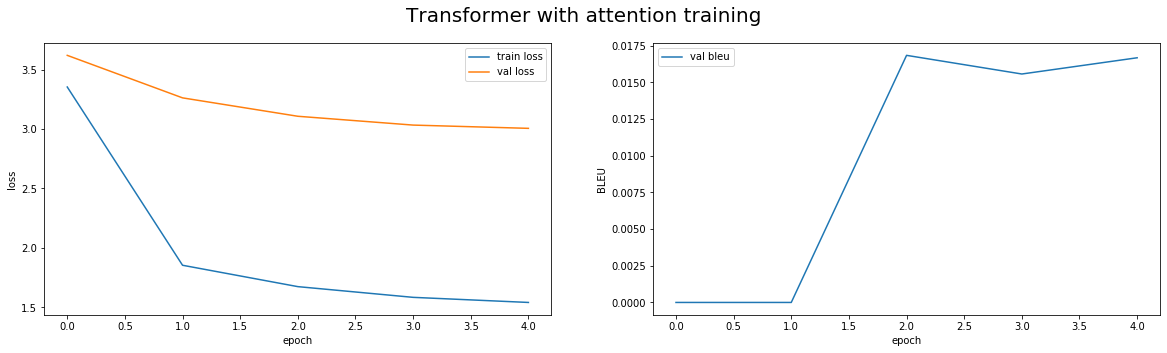

In [61]:
#!g1.1
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='Transformer with attention training')

### Fine-tune pretrained T5 (25 баллов)

Реализуйте Seq2seq Pretrained T5. Воспользуйтесь https://huggingface.co/docs/transformers/model_doc/t5 предобученной моделью. В качестве максимальной длинны возьмите предложения длинной **до 15 слов**, без каких либо префиксов. Архитектура модели(количество слоев, размерность и тд) остается на ваш выбор.

Не забудьте важные аспекты обучения модели:
* Взять готовый t5 токенизатор
* Resize matrix embedding - скорей всего ваша матрица эмбеддингов не будет включать эмбеддинги из вашего сета. Пример обновления матрицы эмбеддингов тут тут https://github.com/runnerup96/Transformers-Tuning/blob/main/t5_encoder_decoder.py
* Learning rate scheduler/Adafactor with constant learning rate


В качестве результатов, приложите следующие данные:
1) Параметры обучения - learning rate, batch_size, epoch_num, pretrained model name
2) Графики обучения - train loss, val loss, bleu score
3) Примеры переводов вашей модели(10 штук) - source text, true target text, predicted target text

In [88]:
#!g1.4
t5_data_config = yaml.load(open("configs/data_t5_config.yaml", 'r'), Loader=yaml.Loader)
t5_model_config = yaml.load(open("configs/model_t5_config.yaml", 'r'), Loader=yaml.Loader)
print_learning_parameters(t5_data_config, t5_model_config)

Parameters of the model:
learning rate: 0.005
batch size: 192
pretrained_model_name: google/t5-efficient-mini


In [77]:
#!g1.4
%pip install sentencepiece huggingface-hub

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.3 MB 1.6 MB/s            
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [84]:
#!g1.4
%pip install huggingface-hub transformers tokenizer

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 79 kB 1.4 MB/s            
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [89]:
#!g1.4
from txt_logger import TXTLogger
from models.seq2seq_t5 import Seq2SeqT5

t5_dm = DataManager(t5_data_config, DEVICE)
t5_train_dataloader, t5_val_dataloader = t5_dm.prepare_data()

if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

t5_model = Seq2SeqT5(
    device=DEVICE,
    pretrained_name=t5_model_config['pretrained_model_name'],
    encoder_vocab_size=len(t5_dm.source_tokenizer.index2word),
    decoder_vocab_size=len(t5_dm.target_tokenizer.index2word),
    target_tokenizer=t5_dm.target_tokenizer,
    start_symbol=t5_dm.target_tokenizer.pad_token,
    lr=t5_model_config['learning_rate'],
    are_source_target_tokenizers_same=t5_model_config['are_source_target_tokenizers_same']
)

t5_logger = TXTLogger(t5_model_config['path_to_log'])
t5_trainer_cls = trainer.Trainer(model=t5_model, model_config=t5_model_config, logger=t5_logger)

if t5_model_config['try_one_batch']:
    train_dataloader = [list(t5_train_dataloader)[0]]
    tran_val_dataloader = [list(t5_val_dataloader)[0]]

t5_trainer_cls.train(t5_train_dataloader, t5_val_dataloader)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1281 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/1281 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/1281 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/1281 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/1281 [00:00<?, ?it/s]

Current BLEU:  0.015878954989688335
не считает что имеет какое то отношение к этому делу ---> не что что не с
давно не получали от тома никаких вестей ---> не неа томаа
убеждён что мэри надо это сделать ---> том с что чтоии это
ты хочешь задать тому несколько вопросов ---> ты хочешь чтобы чтобы том том
считают что этого не случится ---> всё что что не не
##############################
Current BLEU:  0.03265544338603435
утром по пути в школу том столкнулся с мэри ---> прошлой в мэри прошлой прошлой в школу школу
язык на котором том говорит французский ---> язык том говорит говорит говорит говоритфранцузскифранцузски
вижу смысла знакомить его с японской литературой ---> не ответить япопониинии
нет нужды говорить тебе насколько это важно или есть ---> не нужно сказать ты это это
понимаю что вы с томом были друзьями ---> понимаю что ты с с сомом
##############################
Current BLEU:  0.07356349130299715
испытываем совершенно новый способ ---> совершеннонима новое новый
подумываю о т

In [128]:
#!g1.4
import sys  
sys.path.insert(1, "./src")
import torch
import yaml
from models import trainer
from data.datamodule import DataManager
t5_dm = DataManager(t5_data_config, DEVICE)
t5_train_dataloader, t5_val_dataloader = t5_dm.prepare_data()

input_tensor, target_tensor = t5_val_dataloader.__iter__().__next__()
input_tensor = input_tensor[:10]
target_tensor = target_tensor[:10]
with torch.no_grad():
    predicted_samples, _ = t5_model.forward(input_tensor)
bleu_score, target_sentences, predicted_sentences = model.eval_bleu(predicted_samples, target_tensor)
print(f'BLEU score: {bleu_score}')
for source_tokens, target_tokens, predicted_tokens in zip(input_tensor, target_sentences, predicted_sentences):
    source_tokens = ' '.join(t5_dm.source_tokenizer.decode(source_tokens.tolist()))
    print("\nSource: ", source_tokens, "\tTarget: ", target_tokens, "\tPredicted: ", predicted_tokens)

Reading from file: 100%|██████████| 467119/467119 [00:07<00:00, 63535.87it/s]


NameError: name 't5_model' is not defined

In [120]:
#!g1.4
file_content = open(os.path.join(t5_model_config['path_to_log'], "progress_log.txt"), 'r').read().split("\n")
train_loss_list, val_loss_list, val_bleu_list = [], [], []
for line in file_content:
    d = extract_values(line)
    if len(d) > 0:
        train_loss_list.append(d['train_loss'])
        val_loss_list.append(d['val_loss'])
        val_bleu_list.append(d['bleu_score'])
        
len(train_loss_list), len(val_loss_list), len(val_bleu_list)

(4, 4, 4)

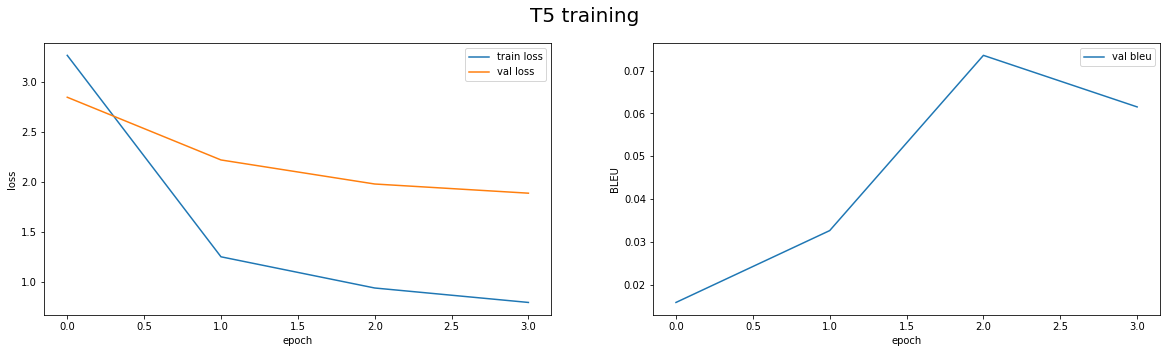

In [121]:
#!g1.4
plot_results(train_loss_list, val_loss_list, val_bleu_list, run_name='T5 training')